In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, mean_squared_error, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer

In [11]:
df = pd.read_csv('../data/weblogs1.csv')

df = df.drop(['ID', 'OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(df)
df = pd.DataFrame(imputer.transform(df), columns=df.columns)

X = df.drop(['ROBOT'], axis=1)
y = df['ROBOT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Decision Tree Classifier

{'max_depth': 29, 'min_samples_leaf': 3, 'min_samples_split': 10}


0.9760881456591388


              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     10337
         1.0       0.94      0.93      0.94      2460

    accuracy                           0.98     12797
   macro avg       0.96      0.96      0.96     12797
weighted avg       0.98      0.98      0.98     12797



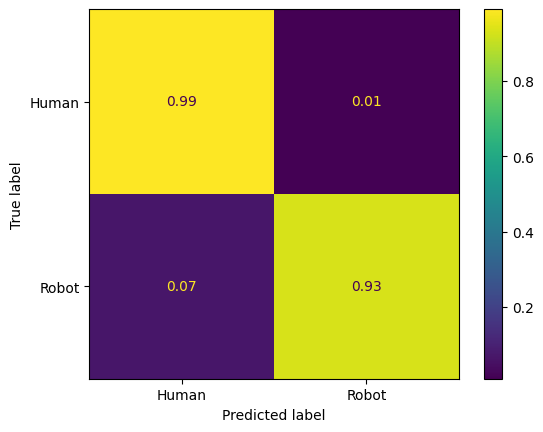

In [12]:
param_grid_dtc = {'max_depth': np.arange(2, 40), 'min_samples_split': np.arange(2, 20, 2), 'min_samples_leaf': np.arange(1, 12, 2)}

grid_search_dtc = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid_dtc, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search_dtc.fit(X_train, y_train)

print(grid_search_dtc.best_params_)
print("\n")

dt_clf = grid_search_dtc.best_estimator_

dt_clf.fit(X_train, y_train)

y_pred_dtc = dt_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_dtc))
print("\n")
print(classification_report(y_test, y_pred_dtc))

cm = np.round(confusion_matrix(y_test, y_pred_dtc, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

### BaggingClassifier (zonder OOB)

0.9541298741892631


              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     10337
         1.0       0.84      0.94      0.89      2460

    accuracy                           0.95     12797
   macro avg       0.91      0.95      0.93     12797
weighted avg       0.96      0.95      0.96     12797



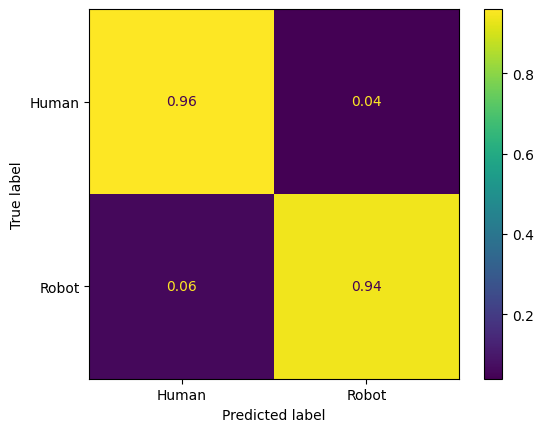

In [14]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)

y_pred_bc = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_bc))
print("\n")
print(classification_report(y_test, y_pred_bc))

cm = np.round(confusion_matrix(y_test, y_pred_bc, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

### BaggingClassifier (met OOB)

In [15]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.9528200519663196

In [16]:
y_pred_oob = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred_oob)

0.9541298741892631

In [17]:
print(classification_report(y_test, y_pred_oob))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     10337
         1.0       0.84      0.94      0.89      2460

    accuracy                           0.95     12797
   macro avg       0.91      0.95      0.93     12797
weighted avg       0.96      0.95      0.96     12797



### AdaBoostClassifier

0.9753848558255841

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     10337
         1.0       0.94      0.93      0.94      2460

    accuracy                           0.98     12797
   macro avg       0.96      0.96      0.96     12797
weighted avg       0.98      0.98      0.98     12797



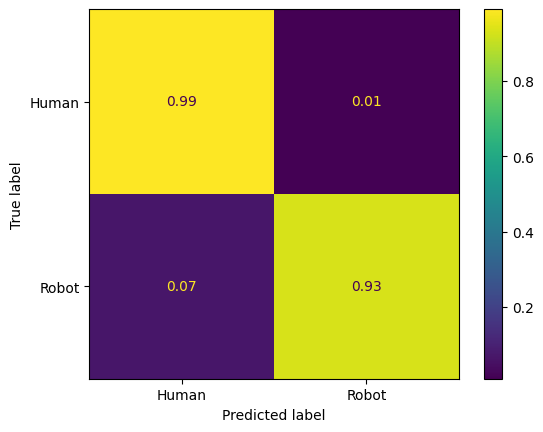

In [18]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

y_pred_ada = ada_clf.predict(X_test)
print(f"{accuracy_score(y_test, y_pred_ada)}\n")

print(classification_report(y_test, y_pred_ada))

cm = np.round(confusion_matrix(y_test, y_pred_ada, normalize='true'), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

### GradientBoostClassfier

0.976869578807533

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     10337
         1.0       0.94      0.94      0.94      2460

    accuracy                           0.98     12797
   macro avg       0.96      0.96      0.96     12797
weighted avg       0.98      0.98      0.98     12797



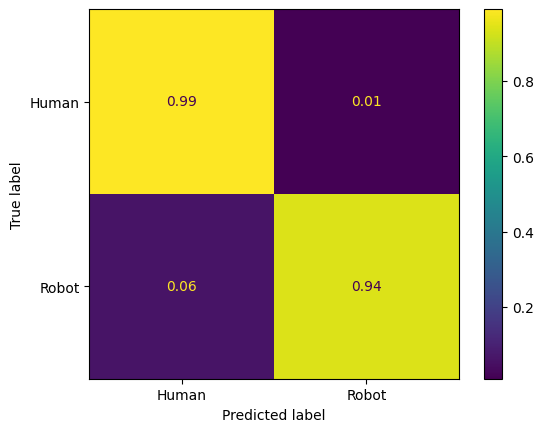

In [19]:
gbrt = GradientBoostingClassifier(max_depth=29, n_estimators=120, learning_rate=0.1, random_state=42)
gbrt.fit(X_train, y_train)

errors_gbrt = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]

best_n_estimators = np.argmin(errors_gbrt) + 1

gbrt_best = GradientBoostingClassifier(max_depth=29, n_estimators=best_n_estimators, learning_rate=0.1, random_state=42)
gbrt_best.fit(X_train, y_train)

y_pred_gbrt = gbrt_best.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_gbrt)}\n")

print(classification_report(y_test, y_pred_gbrt))

cm = np.round(confusion_matrix(y_test, y_pred_gbrt, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

### RandomForestClassfier

{'bootstrap': False, 'max_depth': 25, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 140}
0.9801515980307884

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     10337
         1.0       0.95      0.95      0.95      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.97      0.97     12797
weighted avg       0.98      0.98      0.98     12797



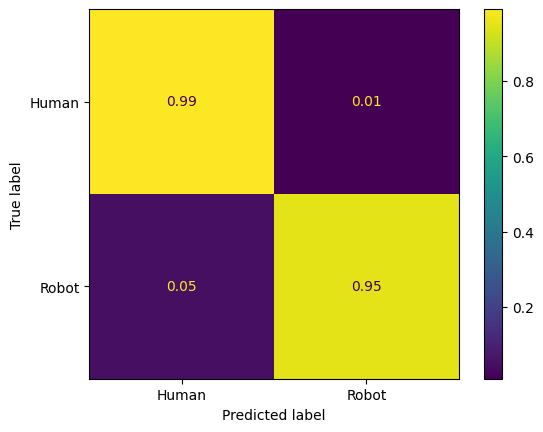

In [21]:
param_grid = {
    'n_estimators': [140],
    'max_depth': [25],
    'min_samples_leaf' : [2],
    'min_samples_split' : [2],
    'max_features' : np.arange(1, 24, 2),
    'bootstrap' : [False],
}

grid_search_rfc = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)

grid_search_rfc.fit(X_train, y_train)

print(grid_search_rfc.best_params_)

rf_clf = grid_search_rfc.best_estimator_
rf_clf.fit(X_train, y_train)

y_pred_rfc = rf_clf.predict(X_test)
print(f"{accuracy_score(y_test, y_pred_rfc)}\n")

print(classification_report(y_test, y_pred_rfc))

cm = np.round(confusion_matrix(y_test, y_pred_rfc, normalize='true'), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

### Save models

In [22]:
filename = '../main_models/decision_tree_classifier_imputed_2.sav'
pickle.dump(dt_clf, open(filename, 'wb'))

filename1 = '../main_models/random_forest_classifier_imputed_2.sav'
pickle.dump(rf_clf, open(filename1, 'wb'))

filename2 = '../main_models/gradient_boosting_classifier_imputed_2.sav'
pickle.dump(gbrt_best, open(filename2, 'wb'))

filename3 = '../main_models/adaboost_classifier_imputed_2.sav'
pickle.dump(ada_clf, open(filename3, 'wb'))

filename4 = '../main_models/bagging_classifier_oob_imputed_2.sav'
pickle.dump(bag_clf, open(filename4, 'wb'))